# model07

## Explain this model

### Model
* Linear models: SVM, Ridge, Lasso

### Features
* uid
* qid
* q_length
* category
* answer
* avg_per_uid: average response time per user
* avg_per_qid: average response time per question

# Let's start our experimemt

## Step1: Read train and test data

### Read files for train and test set
We alread made given csv files as a pickled data for our convenience.

In [286]:
import gzip
import pickle
from numpy import sign

with gzip.open("../data/train.pklz", "rb") as train_file:
    train_set = pickle.load(train_file)

with gzip.open("../data/test.pklz", "rb") as test_file:
    test_set = pickle.load(test_file)

with gzip.open("../data/questions.pklz", "rb") as questions_file:
    questions = pickle.load(questions_file)


for key in train_set:
    train_set[key]['sign_val'] = sign(train_set[key]['position'])

### What they have?
Just look at what each set have.

In [287]:
print ("* train_set:", train_set[1])
print ("* test_set:", test_set[7])
print ("* question keys:", questions[1].keys())

* train_set: {'position': 61.0, 'uid': 0, 'qid': 1, 'answer': 'cole', 'sign_val': 1.0}
* test_set: {'uid': 6, 'qid': 1}
* question keys: dict_keys(['category', 'pos_token', 'group', 'answer', 'question'])


## Step2: Feature Engineering
We might want to use some set of feature based on given data.

In [288]:
from collections import defaultdict
from numpy import sign


"""
Calculate average position(response time) per user(uid) and question(qid).
Param:
    data: dataset
    sign_val: -1 for negetive only, +1 positive only, None both
"""
def get_avg_pos(data, sign_val=None):
    pos_uid = defaultdict(list)
    pos_qid = defaultdict(list)

    for key in data:
        if sign_val and sign(data[key]['position']) != sign_val:
            continue
        uid = data[key]['uid']
        qid = data[key]['qid']
        pos = data[key]['position']
        pos_uid[uid].append(pos)
        pos_qid[qid].append(pos)

    avg_pos_uid = {}
    avg_pos_qid = {}

    for key in pos_uid:
        avg_pos_uid[key] = sum(pos_uid[key]) / len(pos_uid[key])

    for key in pos_qid:
        avg_pos_qid[key] = sum(pos_qid[key]) / len(pos_qid[key])
    
    return [avg_pos_uid, avg_pos_qid]


"""
Make feature vectors for given data set
"""
def featurize(data, avg_pos, sign_val=None):
    X = []
    avg_pos_uid = avg_pos[0]
    avg_pos_qid = avg_pos[1]
    for key in data:
        if sign_val and data[key]['sign_val'] != sign_val:
            continue
        uid = data[key]['uid']
        qid = data[key]['qid']
        q_length = max(questions[qid]['pos_token'].keys())
        category = questions[qid]['category'].lower()
        answer = questions[qid]['answer'].lower()
        if uid in avg_pos_uid:
            pos_uid = avg_pos_uid[uid]
        else:
            pos_uid = sum(avg_pos_uid.values()) / float(len(avg_pos_uid.values()))
            
        if qid in avg_pos_qid:
            pos_qid = avg_pos_qid[qid]
        else:
            pos_qid = sum(avg_pos_qid.values()) / float(len(avg_pos_qid.values()))
            
        feat = {"uid": str(uid),
                "qid": str(qid),
                "q_length": q_length,
                "category": category,
                "answer": answer,
                "sign_val": data[key]['sign_val'],
                "avg_pos_uid": pos_uid,
                "avg_pos_qid": pos_qid
               }
        X.append(feat)
    
    return X

"""
Temporary: (test only)Make feature vectors for given data set
"""
def featurize_test(data):
    X = []
    for key in data:
        uid = data[key]['uid']
        qid = data[key]['qid']
        q_length = max(questions[qid]['pos_token'].keys())
        category = questions[qid]['category'].lower()
        answer = questions[qid]['answer'].lower()
        feat = {"uid": str(uid),
                "qid": str(qid),
                "q_length": q_length,
                "category": category,
                "answer": answer,
               }
        X.append(feat)
    
    return X


"""
Get positions
"""
def get_positions(data, sign_val=None):
    Y = []
    for key in data:
        if sign_val and sign(data[key]['position']) != sign_val:
            continue
        position = data[key]['position']
        Y.append(position)
    
    return Y

"""
Select values by keys only
"""
def select_keys(data, keys):
    unwanted = data[0].keys() - keys
    for item in data:
        for unwanted_key in unwanted:
            del item[unwanted_key]
    return data

In [289]:
X_train_pos = featurize(train_set, get_avg_pos(train_set, sign_val=1), sign_val=1)
X_train_pos[0]

{'answer': 'thomas cole',
 'avg_pos_qid': 69.42857142857143,
 'avg_pos_uid': 82.01930501930502,
 'category': 'fine arts',
 'q_length': 77,
 'qid': '1',
 'sign_val': 1.0,
 'uid': '0'}

Look at the feature vector.

In [290]:
regression_keys = ['avg_pos_uid', 'avg_pos_qid', 'category', 'q_length', "sign_val"]
X_train_pos = featurize(train_set, get_avg_pos(train_set, sign_val=1), sign_val=1)
X_train_pos = select_keys(X_train_pos, regression_keys)
Y_train_pos = get_positions(train_set, sign_val=1)
print(len(X_train_pos))
print(len(Y_train_pos))
X_train_pos[0], Y_train_pos[0]

20819
20819


({'avg_pos_qid': 69.42857142857143,
  'avg_pos_uid': 82.01930501930502,
  'category': 'fine arts',
  'q_length': 77,
  'sign_val': 1.0},
 61.0)

In [291]:
X_train_neg = featurize(train_set, get_avg_pos(train_set, sign_val=-1), sign_val=-1)
X_train_neg = select_keys(X_train_neg, regression_keys)
Y_train_neg = get_positions(train_set, sign_val=-1)
print (len(X_train_neg))
print (len(Y_train_neg))
print (X_train_neg[5], Y_train_neg[5])

7675
7675
{'sign_val': -1.0, 'avg_pos_uid': -83.25, 'category': 'literature', 'q_length': 128, 'avg_pos_qid': -128.25} -129.0


{'astronomy', 'social studies', 'earth science', 'history', 'literature', 'mathematics', 'physics', 'fine arts', 'chemistry', 'other', 'biology'}


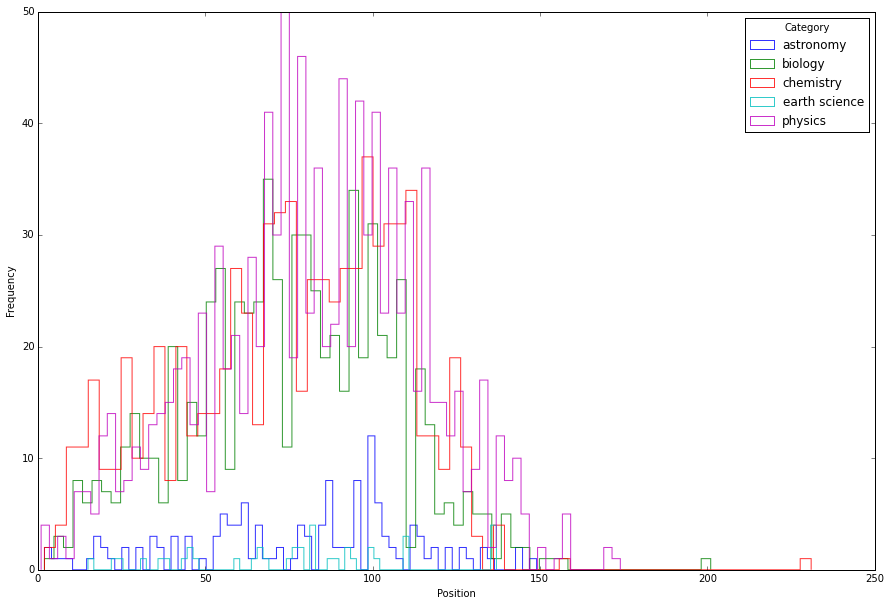

In [292]:
%matplotlib inline
import matplotlib.pyplot as plt

cat = [[item['category'], Y_train_pos[ii]] for ii, item in enumerate(X_train_pos)]
print (set([item[0] for item in cat]))

plt.figure(figsize=(15, 10), dpi=400)
plt.xlabel("Position")
plt.ylabel("Frequency")
#for category in set([item[0] for item in cat]):
for category in ['astronomy','biology', 'chemistry', 'earth science', 'physics']:
    plt.hist([item[1] for item in cat if item[0]==category],
             bins=70,
             histtype="step",
             alpha=.8,
             label=category
            )
    plt.legend(title='Category')

{'astronomy', 'social studies', 'earth science', 'history', 'literature', 'mathematics', 'physics', 'fine arts', 'chemistry', 'other', 'biology'}


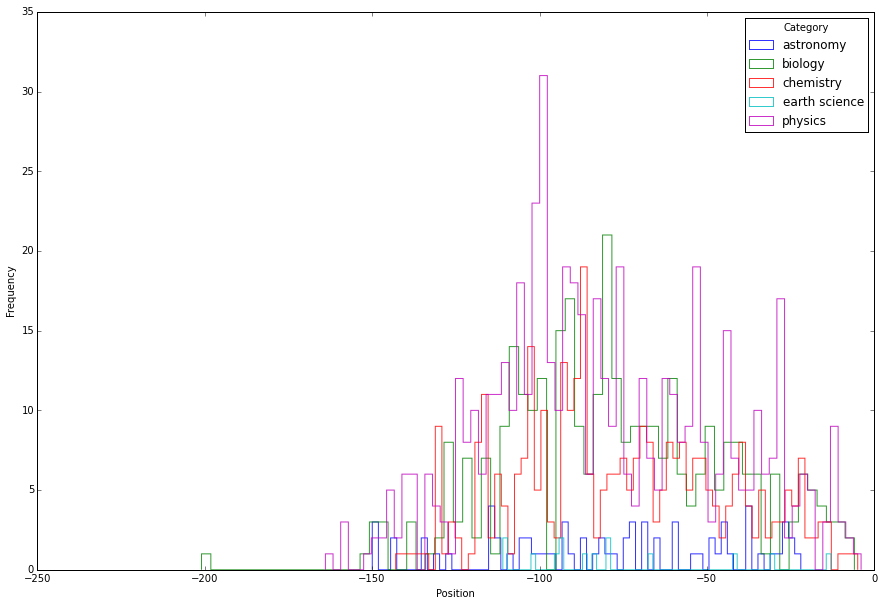

In [293]:
cat = [[item['category'], Y_train_neg[ii]] for ii, item in enumerate(X_train_neg)]
print (set([item[0] for item in cat]))

plt.figure(figsize=(15, 10), dpi=400)
plt.xlabel("Position")
plt.ylabel("Frequency")
#for category in set([item[0] for item in cat]):
for category in ['astronomy','biology', 'chemistry', 'earth science', 'physics']:
    plt.hist([item[1] for item in cat if item[0]==category],
             bins=70,
             histtype="step",
             alpha=.8,
             label=category
            )
    plt.legend(title='Category')

## Step3: Cross varidation

In [294]:
import multiprocessing
from sklearn import linear_model
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction import DictVectorizer
import math
from numpy import abs, sqrt

vec = DictVectorizer()
X_train_pos = vec.fit_transform(X_train_pos)

regressor_names = """
LinearRegression
Ridge
Lasso
ElasticNet
"""
print ("=== Linear Cross validation RMSE scores:")
for regressor in regressor_names.split():
    scores = cross_val_score(getattr(linear_model, regressor)(),
                             X_train_pos, Y_train_pos,
                             cv=10,
                             scoring='mean_squared_error',
                             n_jobs=multiprocessing.cpu_count()-1
                            )
    print (regressor, sqrt(abs(scores)).mean())

=== Linear Cross validation RMSE scores:
LinearRegression 20.9786158657
Ridge 21.3055902371
Lasso 20.9702655622
ElasticNet 20.9702478838


In [295]:
X_train_neg = vec.fit_transform(X_train_neg)
for regressor in regressor_names.split():
    scores = cross_val_score(getattr(linear_model, regressor)(),
                             X_train_neg, Y_train_neg,
                             cv=10,
                             scoring='mean_squared_error',
                             n_jobs=multiprocessing.cpu_count()-1
                            )
    print (regressor, sqrt(abs(scores)).mean())

LinearRegression 20.6051987904
Ridge 20.8181271328
Lasso 20.5990567095
ElasticNet 20.5990399413


In [296]:
svm_keys = ['qid', 'uid', 'q_length', 'category', 'answer']
X_train = featurize(train_set, get_avg_pos(train_set))
X_train = select_keys(X_train, svm_keys)
Y_train = get_positions(train_set)
print (len(X_train))
print (len(Y_train))
print (X_train[0], Y_train[0])
Y_train = get_positions(train_set)
X_train = vec.fit_transform(X_train)

28494
28494
{'qid': '1', 'category': 'fine arts', 'uid': '0', 'q_length': 77, 'answer': 'thomas cole'} 61.0


In [297]:
from numpy import sign
import numpy as np
from sklearn import svm, grid_search
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV


for kernel in ['rbf']:
    svr = svm.SVC(kernel=kernel, gamma=0.1)
    scores = cross_val_score(svr,
                             X_train, sign(Y_train),
                             cv=10,
                             scoring=None,
                             n_jobs=multiprocessing.cpu_count()-1
                            )
    print (kernel)
    print (scores)
    print (scores.mean())

rbf
[ 0.73122807  0.6522807   0.73087719  0.70210526  0.60701754  0.61179361
  0.7016497   0.66900667  0.6995437   0.73103933]
0.683654177977


## Step4: Prediction

In [298]:
svm_keys = ['qid', 'uid', 'q_length', 'category', 'answer']
X_train = featurize(train_set, get_avg_pos(train_set))
X_train = select_keys(X_train, svm_keys)
Y_train = get_positions(train_set)

In [299]:
X_test = featurize_test(test_set)
X_test = select_keys(X_test, svm_keys)

In [300]:
X_train_length = len(X_train)
X = vec.fit_transform(X_train + X_test)
X_train = X[:X_train_length]
X_test = X[X_train_length:]

In [301]:
svr = svm.SVC(kernel='rbf', gamma=0.1)
svr.fit(X_train, sign(Y_train))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.1,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [302]:
predictions = svr.predict(X_test)

In [303]:
print (len(sign(Y_train)))
print (sum(sign(Y_train)))
print (len(predictions))
print (predictions.sum())

28494
13144.0
4749
4241.0


In [304]:
regression_keys = ['avg_pos_uid', 'avg_pos_qid', 'q_length', 'sign_val']
avg_pos_pos = get_avg_pos(train_set, sign_val=1)
X_train_pos = featurize(train_set, avg_pos_pos, sign_val=1)
X_train_pos = select_keys(X_train_pos, regression_keys)
Y_train_pos = get_positions(train_set, sign_val=1)

avg_pos_neg = get_avg_pos(train_set, sign_val=-1)
X_train_neg = featurize(train_set, avg_pos_neg, sign_val=-1)
X_train_neg = select_keys(X_train_neg, regression_keys)
Y_train_neg = get_positions(train_set, sign_val=-1)

X_test = test_set

In [305]:
for index, key in enumerate(X_test):
    X_test[key]['sign_val'] = predictions[index]

In [306]:
X_test_final = []
for index, key in enumerate(X_test):
    if predictions[index] == 1.0:
        X_test_final.append(featurize({key: X_test[key]}, avg_pos_pos, sign_val=1)[0])
    else:
        X_test_final.append(featurize({key: X_test[key]}, avg_pos_neg, sign_val=-1)[0])

In [307]:
regression_keys = ['avg_pos_uid', 'avg_pos_qid', 'q_length', 'sign_val']
X_train_pos = featurize(train_set, get_avg_pos(train_set, sign_val=1), sign_val=1)
X_train_pos = select_keys(X_train_pos, regression_keys)
Y_train_pos = get_positions(train_set, sign_val=1)

X_train_neg = featurize(train_set, get_avg_pos(train_set, sign_val=-1), sign_val=-1)
X_train_neg = select_keys(X_train_neg, regression_keys)
Y_train_neg = get_positions(train_set, sign_val=-1)

In [308]:
X_train_pos = vec.fit_transform(X_train_pos)
X_train_neg = vec.fit_transform(X_train_neg)

In [309]:
regressor_pos = linear_model.Lasso()
regressor_pos.fit(X_train_pos, Y_train_pos)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [310]:
regressor_neg = linear_model.Lasso()
regressor_neg.fit(X_train_neg, Y_train_neg)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [311]:
X_test_final = select_keys(X_test_final, regression_keys)

In [312]:
X_test_final_vec = vec.fit_transform(X_test_final)
final_predictions = []
for index, item in enumerate(X_test_final):
    if item['sign_val'] == 1.0:
        final_predictions.append(regressor_pos.predict(X_test_final_vec[index])[0])
    else:
        final_predictions.append(regressor_neg.predict(X_test_final_vec[index])[0])

In [313]:
final_predictions = sorted([[id, final_predictions[index]] for index, id in enumerate(test_set.keys())])
print (len(final_predictions))
final_predictions[:5]

4749


[[7, 55.957411241442216],
 [14, 72.142308264923827],
 [21, 70.161034784750882],
 [28, 58.181064927561664],
 [35, 64.663691941971933]]

## Step5: Writing submission.

In [314]:
import csv


final_predictions.insert(0,["id", "position"])
with open('guess.csv', 'w') as fp:
    writer = csv.writer(fp, delimiter=',')
    writer.writerows(final_predictions)